In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tools import eval_measures
from sklearn.linear_model import LinearRegression
from haversine import haversine, Unit
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
import scipy
import seaborn as sns

In /Users/joshuaneronha/.conda/envs/cs1951a/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/joshuaneronha/.conda/envs/cs1951a/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/joshuaneronha/.conda/envs/cs1951a/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/joshuaneronha/.conda/envs/cs1951a/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor rele

<h2>Clean Airport Data</h2>

In [2]:
raw = pd.read_csv('./resources/Airports2.csv')
raw.head()

Origin_airport Destination_airport    Origin_city Destination_city  \
0            MHK                 AMW  Manhattan, KS         Ames, IA   
1            EUG                 RDM     Eugene, OR         Bend, OR   
2            EUG                 RDM     Eugene, OR         Bend, OR   
3            EUG                 RDM     Eugene, OR         Bend, OR   
4            MFR                 RDM    Medford, OR         Bend, OR   

   Passengers  Seats  Flights  Distance    Fly_date  Origin_population  \
0          21     30        1       254  2008-10-01             122049   
1          41    396       22       103  1990-11-01             284093   
2          88    342       19       103  1990-12-01             284093   
3          11     72        4       103  1990-10-01             284093   
4           0     18        1       156  1990-02-01             147300   

   Destination_population  Org_airport_lat  Org_airport_long  \
0                   86219        39.140999        -96.670799   
1                   76034        44.124599       -123.211998   
2                   76034        44.124599       -123.211998   
3                   76034        44.124599       -123.211998   
4                   76034        42.374199       -122.873001   

   Dest_airport_lat  Dest_airport_long  
0               NaN                NaN  
1         44.254101        -121.150002  
2         44.254101        -121.150002  
3         44.254101        -121.150002  
4         44.254101        -121.150002

In [3]:
cleaned = raw.drop_duplicates('Origin_airport')
cleaned = cleaned[['Origin_airport','Origin_population']]
cleaned = cleaned.set_index('Origin_airport')
cleaned.head()

Origin_population
Origin_airport                   
MHK                        122049
EUG                        284093
MFR                        147300
SEA                       5154164
PDX                       1534762

In [4]:
raw = pd.read_csv('./resources/q3_2019.csv')
raw.head()

MARKET_COUPONS ORIGIN DEST TK_CARRIER_GROUP  PASSENGERS  MARKET_FARE  \
0               1    ORD  CLT               AA        23.0        180.5   
1               1    CLT  ORD               AA         5.0        181.0   
2               1    ORD  CLT               AA         5.0        181.0   
3               1    CLT  ORD               AA        54.0        181.5   
4               1    ORD  CLT               AA        54.0        181.5   

   MARKET_DISTANCE  Unnamed: 7  
0            599.0         NaN  
1            599.0         NaN  
2            599.0         NaN  
3            599.0         NaN  
4            599.0         NaN

In [5]:
pax = raw[['ORIGIN','PASSENGERS']].groupby('ORIGIN').sum()
wtavg = lambda x: np.average(x.ORIGIN[:, :2], weights = x.PASSENGERS, axis = 0)
q = raw[['ORIGIN','MARKET_COUPONS','MARKET_DISTANCE','PASSENGERS','MARKET_FARE']].groupby('ORIGIN').apply(lambda x: np.average(x, weights = x.PASSENGERS, axis = 0))
weighted_grouped = pd.DataFrame(q).apply(lambda x: x.to_list())
weighted_grouped.columns = ['vals']
sorted_wg = pd.DataFrame(weighted_grouped.vals.tolist(), index= weighted_grouped.index)
sorted_wg.columns = ['market_coupons','market_distance','passengers','market_fare']
sorted_wg = sorted_wg[['market_coupons','market_distance','market_fare']]
airport_data = sorted_wg.join(pax)
airport_data = airport_data[airport_data['PASSENGERS'] > 1000]
airport_data.join(cleaned, how='left').to_csv('airports_new.csv')
airport_data.join(cleaned, how='left').head()

market_coupons  market_distance  market_fare  PASSENGERS  \
ORIGIN                                                             
ABE           1.490420      1033.379959   185.441812     11796.0   
ABI           2.040907      1083.881715   271.837137      2029.0   
ABQ           1.504314      1116.205418   200.709669     65491.0   
ACK           1.350364       577.105188   228.857112      6322.0   
ACT           2.058899      1032.135083   267.283835      1562.0   

        Origin_population  
ORIGIN                     
ABE              712594.0  
ABI              152888.0  
ABQ              834685.0  
ACK                   NaN  
ACT              191064.0

<p>Unfortunately, this dataset did not contain population data for every city (for example ACK (Nantucket) above). As a result, for these cities, I manually entered 2019 estimates of the metro area populations for these cities</p>

<h2>Joining Nonstop Routes with Airport Data</h2>

In [6]:
airports = pd.read_csv('./resources/airports.csv') #import airports csv generated in other file
codes = pd.read_csv('./resources/airport-codes_csv.csv') #and airport codes!

In [7]:
nonstops = pd.read_csv('./resources/nonstops.csv') #cleaned CSV with all nonstop itineraries in Q3 2019
all_flights = pd.read_csv('./resources/all.csv') #similarly importing all itineraries, cleaned or not

In [8]:
origin_merged = pd.merge(nonstops,airports,left_on = 'origin', right_on = 'ORIGIN',suffixes = ('_route',''))
merged = pd.merge(origin_merged,airports,left_on = 'dest', right_on = 'ORIGIN',suffixes = ('_origin','_dest'))

In [9]:
merged = merged[['origin','dest','market_distance_route','market_fare_route','PASSENGERS_route','market_coupons_origin','market_distance_origin','market_fare_origin','PASSENGERS_origin','Origin_population_origin','market_coupons_dest','market_distance_dest','market_fare_dest','PASSENGERS_dest','Origin_population_dest']]
merged.head()

origin dest  market_distance_route  market_fare_route  PASSENGERS_route  \
0    ABE  ATL                  692.0         231.733727             542.0   
1    ABQ  ATL                 1269.0         262.495056             718.0   
2    ACY  ATL                  679.0          50.621531            1261.0   
3    ALB  ATL                  853.0         230.006320            1155.0   
4    AUS  ATL                  813.0         141.007882            5869.0   

   market_coupons_origin  market_distance_origin  market_fare_origin  \
0               1.490420             1033.379959          185.441812   
1               1.504314             1116.205418          200.709669   
2               1.027258              855.227517           61.978701   
3               1.619641             1305.322100          228.938693   
4               1.342153             1191.393869          178.742280   

   PASSENGERS_origin  Origin_population_origin  market_coupons_dest  \
0              11796                    712594             1.104893   
1              65491                    834685             1.104893   
2              10786                    236224             1.104893   
3              37625                    819105             1.104893   
4             189342                    874516             1.104893   

   market_distance_dest  market_fare_dest  PASSENGERS_dest  \
0            910.687864        188.711991           448391   
1            910.687864        188.711991           448391   
2            910.687864        188.711991           448391   
3            910.687864        188.711991           448391   
4            910.687864        188.711991           448391   

   Origin_population_dest  
0                 3087755  
1                 3087755  
2                 3087755  
3                 3087755  
4                 3087755

<AxesSubplot:>

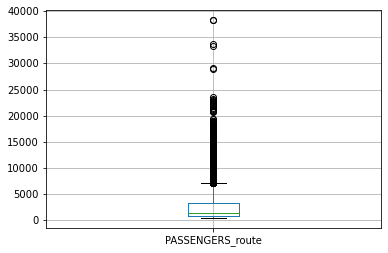

In [10]:
merged.boxplot('PASSENGERS_route')

<p>We see a lot of variation / outliers here -- note the average route box stops at about 3000 passengers, but there are many other more populous routes that act as outliers. Including these outlier airports negatively affects the model's accuracy due to the fact that there are so few of them, so we exclude any routes from the model with fewer than 7800 ten percent passengers in a quarter (roughly any flights with more than 850 PDEW).</p>

<h2>Building The Models</h2>

In [1303]:
origin_merged = pd.merge(nonstops,airports,left_on = 'origin', right_on = 'ORIGIN',suffixes = ('_route',''))
merged = pd.merge(origin_merged,airports,left_on = 'dest', right_on = 'ORIGIN',suffixes = ('_origin','_dest'))

merged = merged[merged['PASSENGERS_route'] < 35000]

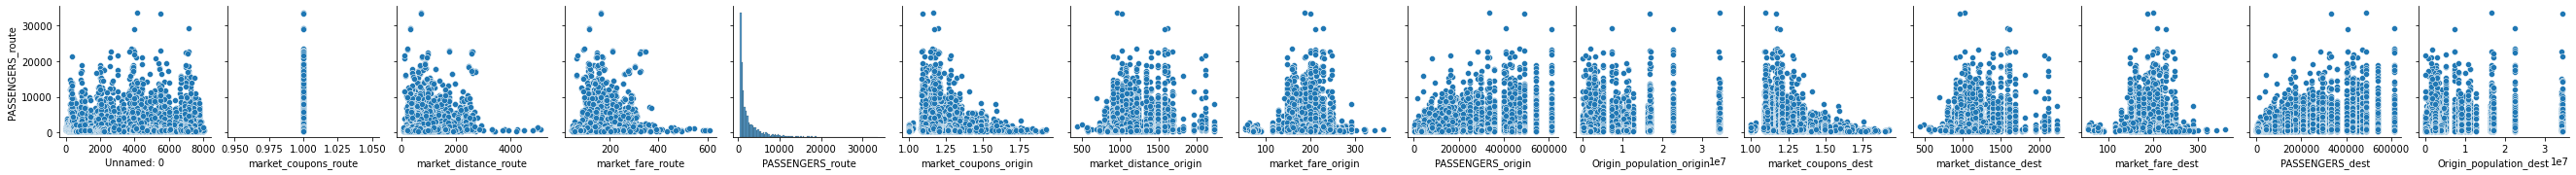

In [1304]:
sns.pairplot(merged,y_vars='PASSENGERS_route')

In [1311]:
#we choose these as the variables we wish to fit our model with

y = merged['PASSENGERS_route']
X = merged[['market_distance_route','market_fare_origin','market_coupons_origin','market_distance_origin','PASSENGERS_origin','market_fare_dest','market_coupons_dest','market_distance_dest','PASSENGERS_dest']]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<h3>Neural Network</h3>

In [1315]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# X_train_n = np.append(X_train,[[5000,500,2.5,5000,1000,500,2.5,5000,1000]],axis=0)
# y_train = np.append(y_train,0)
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.transform(X_test)
# X_train_n = X_train
# X_test_n = X_test

In [1316]:
len(X_train)

3058

In [1317]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
import tensorflow as tf

In [1430]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)

model = Sequential()

# model.add(Dense(9,activation='relu'))
# model.add(Dense(16,activation='relu',input_dim=9))
# model.add(Dense(16,activation='relu'))
model.add(Dense(32,activation='relu',input_dim=9))
model.add(Dense(64,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
# model.add(Dense(4,activation='relu'))
# model.add(Dense(4,activation='relu'))
# model.add(Dense(4,activation='relu'))
# model.add(Dense(8,activation='relu'))
# model.add(Dense(16,activation='relu'))


# model.add(Dense(64,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(128,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(32,activation='relu'))
# model.add(Dense(128,activation='relu'))
# model.add(Dense(128,activation='relu'))

# model.add(Dense(512,activation='relu'))
# model.add(Dense(512,activation='relu'))
# model.add(Dense(512,activation='relu'))
# # model.add(Dense(18,activation='relu'))
# # model.add(Dense(64,activation='relu'))
# # model.add(Dense(64,activation='relu'))

model.add(Dense(1))

model.compile(optimizer='Adam',loss='mse',metrics=['mse'])

In [1431]:
model.fit(x=X_train_n,y=y_train.values,verbose=1,
          validation_data=(X_test_n,y_test.values),
          batch_size=64,epochs=500,callbacks=[callback])

Epoch 1/500
48/48 [==============================] - 1s 4ms/step - loss: 18248947.4694 - mse: 18248947.4694 - val_loss: 21499440.0000 - val_mse: 21499440.0000
Epoch 2/500
48/48 [==============================] - 0s 2ms/step - loss: 16693508.6735 - mse: 16693508.6735 - val_loss: 12607163.0000 - val_mse: 12607163.0000
Epoch 3/500
48/48 [==============================] - 0s 2ms/step - loss: 11906409.0816 - mse: 11906409.0816 - val_loss: 11662826.0000 - val_mse: 11662826.0000
Epoch 4/500
48/48 [==============================] - 0s 3ms/step - loss: 11052499.7347 - mse: 11052499.7347 - val_loss: 10686490.0000 - val_mse: 10686490.0000
Epoch 5/500
48/48 [==============================] - 0s 2ms/step - loss: 8745422.6633 - mse: 8745422.6633 - val_loss: 9272641.0000 - val_mse: 9272641.0000
Epoch 6/500
48/48 [==============================] - 0s 2ms/step - loss: 8312515.6224 - mse: 8312515.6224 - val_loss: 7576457.0000 - val_mse: 7576457.0000
Epoch 7/500
48/48 [==============================] - 0

48/48 [==============================] - 0s 2ms/step - loss: 3480974.8673 - mse: 3480974.8673 - val_loss: 3705960.7500 - val_mse: 3705960.7500
Epoch 54/500
48/48 [==============================] - 0s 2ms/step - loss: 3479383.5051 - mse: 3479383.5051 - val_loss: 3795844.5000 - val_mse: 3795844.5000
Epoch 55/500
48/48 [==============================] - 0s 2ms/step - loss: 3851527.7245 - mse: 3851527.7245 - val_loss: 3689030.0000 - val_mse: 3689030.0000
Epoch 56/500
48/48 [==============================] - 0s 2ms/step - loss: 3329459.4949 - mse: 3329459.4949 - val_loss: 3766124.7500 - val_mse: 3766124.7500
Epoch 57/500
48/48 [==============================] - 0s 2ms/step - loss: 3662552.5714 - mse: 3662552.5714 - val_loss: 3675146.2500 - val_mse: 3675146.2500
Epoch 58/500
48/48 [==============================] - 0s 2ms/step - loss: 3569528.5714 - mse: 3569528.5714 - val_loss: 3696990.7500 - val_mse: 3696990.7500
Epoch 59/500
48/48 [==============================] - 0s 2ms/step - loss: 314

48/48 [==============================] - 0s 2ms/step - loss: 2757245.9311 - mse: 2757245.9311 - val_loss: 3476080.0000 - val_mse: 3476080.0000
Epoch 106/500
48/48 [==============================] - 0s 2ms/step - loss: 3173590.6276 - mse: 3173590.6276 - val_loss: 3354350.0000 - val_mse: 3354350.0000
Epoch 107/500
48/48 [==============================] - 0s 2ms/step - loss: 2596443.8622 - mse: 2596443.8622 - val_loss: 3383199.0000 - val_mse: 3383199.0000
Epoch 108/500
48/48 [==============================] - 0s 2ms/step - loss: 2887300.3010 - mse: 2887300.3010 - val_loss: 3349773.5000 - val_mse: 3349773.5000
Epoch 109/500
48/48 [==============================] - 0s 2ms/step - loss: 3000142.0816 - mse: 3000142.0816 - val_loss: 3358781.5000 - val_mse: 3358781.5000
Epoch 110/500
48/48 [==============================] - 0s 2ms/step - loss: 3188990.7959 - mse: 3188990.7959 - val_loss: 3523734.5000 - val_mse: 3523734.5000
Epoch 111/500
48/48 [==============================] - 0s 2ms/step - los

48/48 [==============================] - 0s 3ms/step - loss: 3352744.6582 - mse: 3352744.6582 - val_loss: 3345376.2500 - val_mse: 3345376.2500
Epoch 158/500
48/48 [==============================] - 0s 2ms/step - loss: 2575205.2245 - mse: 2575205.2245 - val_loss: 3256110.7500 - val_mse: 3256110.7500
Epoch 159/500
48/48 [==============================] - 0s 2ms/step - loss: 2498090.8750 - mse: 2498090.8750 - val_loss: 3158891.0000 - val_mse: 3158891.0000
Epoch 160/500
48/48 [==============================] - 0s 2ms/step - loss: 2228499.9515 - mse: 2228499.9515 - val_loss: 3141042.7500 - val_mse: 3141042.7500
Epoch 161/500
48/48 [==============================] - 0s 2ms/step - loss: 2946324.6429 - mse: 2946324.6429 - val_loss: 3117495.7500 - val_mse: 3117495.7500
Epoch 162/500
48/48 [==============================] - 0s 2ms/step - loss: 2517620.9082 - mse: 2517620.9082 - val_loss: 3284883.2500 - val_mse: 3284883.2500
Epoch 163/500
48/48 [==============================] - 0s 2ms/step - los

<AxesSubplot:>

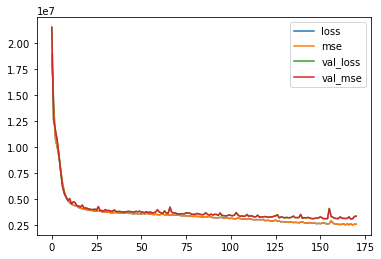

In [1432]:
losses = pd.DataFrame(model.history.history)
losses.plot()

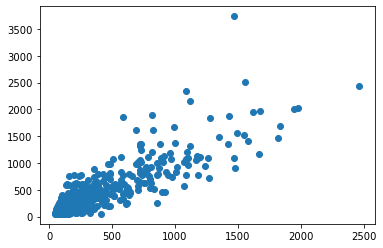

In [1433]:
plt.scatter(model.predict(X_test_n)/9,y_test/9)

In [1434]:
r2_score(y_test,model.predict(X_test_n))

0.746590220336345

In [1435]:
def model_predict(origin,dest):
    zero = 1.0
    two = (airports[airports['ORIGIN'] == origin]['market_fare'].values[0])
    three = (airports[airports['ORIGIN'] == origin]['market_coupons'].values[0])
    four = (airports[airports['ORIGIN'] == origin]['market_distance'].values[0])
    five = (((airports[airports['ORIGIN'] == origin]['PASSENGERS'].values[0])))
    six = (airports[airports['ORIGIN'] == dest]['market_fare'].values[0])
    seven = (airports[airports['ORIGIN'] == dest]['market_coupons'].values[0])
    eight = (airports[airports['ORIGIN'] == dest]['market_distance'].values[0])
    nine = (((airports[airports['ORIGIN'] == dest]['PASSENGERS'].values[0])))
    
    
    origin_joint = codes[codes['iata_code'] == origin]['coordinates'].values[0].split(', ')
    origin_ll = (float(origin_joint[1]),float(origin_joint[0]))
    ll_out = float(origin_joint[0]),float(origin_joint[1])
    
    dest_joint = codes[codes['iata_code'] == dest]['coordinates'].values[0].split(', ')
    dest_ll = (float(dest_joint[1]),float(dest_joint[0]))
    dest_ll_out = (float(dest_joint[0]),float(dest_joint[1]))
    route_dist = haversine(origin_ll,dest_ll,unit='mi')

    one = (route_dist)
    
    origin_pop = airports[airports['ORIGIN'] == origin]['Origin_population'].values[0]
    dest_pop = airports[airports['ORIGIN'] == dest]['Origin_population'].values[0]
    arr = np.asarray([one,two,three,four,five,six,seven,eight,nine])
    return model.predict(scaler.transform(arr.reshape(-1, 9)))*10/90
#     return (model.predict([zero,one,two,three,four,five,six,seven,eight,nine])[0]*10/90)


#     results.predict([1,1,1,1,1,1,1,1,1,1])[0]

In [1436]:
model_predict('ACK','EAT')[0][0]

39.75524

In [1441]:
model_predict('PVD','ICT')[0][0]

59.06334

In [733]:
save_model = model

In [765]:
save_model_2 = model

In [1354]:
save_model_3 = model

In [1442]:
save_model_4 = model

<h3>Regression</h3>

In [526]:
X_train_R = sm.add_constant(X_train)
X_test_R = sm.add_constant(X_test)

#we use a Poisson distribution to avoid negative values for small predicted flights!

model_R = sm.GLM(y_train, X_train_R, hasconst = True, family=sm.families.Poisson())

results = model_R.fit()

y_est_tr = results.predict(X_train_R)
y_est_te = results.predict(X_test_R)

training_MSE = eval_measures.mse(y_train,y_est_tr)
testing_MSE = eval_measures.mse(y_test,y_est_te)

print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:       PASSENGERS_route   No. Observations:                 3058
Model:                            GLM   Df Residuals:                     3048
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4318e+06
Date:                Thu, 06 May 2021   Deviance:                   2.8354e+06
Time:                        15:33:58   Pearson chi2:                 3.15e+06
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11

In [527]:
print(training_MSE,testing_MSE)

4693707.040194832 4887613.767773097


<p>We see similar MSEs for training and testing, indicating that we have produced a decent model.</p>
<p>Next, we run this model for a variety of different test/train samples to assess its reproducibility for different cutoffs for max passenger flights.</p>

In [219]:
trainMSE = []
diff = []

for j in [3,8,32,42]:
    origin_merged = pd.merge(nonstops,airports,left_on = 'origin', right_on = 'ORIGIN',suffixes = ('_route',''))
    merged = pd.merge(origin_merged,airports,left_on = 'dest', right_on = 'ORIGIN',suffixes = ('_origin','_dest'))
    inside_MSE = []
    inside_diff = []
    for i in np.linspace(50000,500,100):
        merged = merged[merged['PASSENGERS_route'] < i]

        y = merged['PASSENGERS_route']
        X = merged[['market_distance_route','market_fare_origin','market_coupons_origin','market_distance_origin','PASSENGERS_origin','market_fare_dest','market_coupons_dest','market_distance_dest','PASSENGERS_dest']]
        # X = merged['market_distance_route']

    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = j)


        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)

        model = sm.GLM(y_train, X_train, hasconst = True, family=sm.families.Poisson())
        results = model.fit()

        y_est_tr = results.predict(X_train)
        y_est_te = results.predict(X_test)

        training_MSE = eval_measures.mse(y_train,y_est_tr)
        testing_MSE = eval_measures.mse(y_test,y_est_te)
        inside_MSE.append(training_MSE)
        inside_diff.append((testing_MSE - training_MSE) / training_MSE)
    trainMSE.append(inside_MSE)
    diff.append(inside_diff)

Text(0, 0.5, 'Percent Difference')

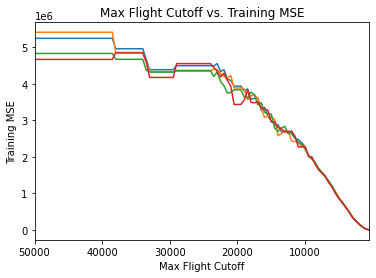

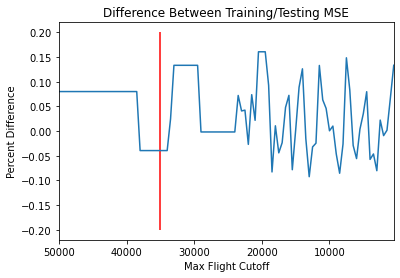

In [220]:
fig, ax = plt.subplots()

ax.plot(np.linspace(50000,500,100),np.array(trainMSE[0]))
ax.plot(np.linspace(50000,500,100),np.array(trainMSE[1]))
ax.plot(np.linspace(50000,500,100),np.array(trainMSE[2]))
ax.plot(np.linspace(50000,500,100),np.array(trainMSE[3]))
ax.set_xlim([50000,500])
plt.title('Max Flight Cutoff vs. Training MSE')
plt.xlabel('Max Flight Cutoff')
plt.ylabel('Training MSE')

fig2, ax2 = plt.subplots()

# ax2.plot(np.linspace(50000,500,100),diff[0])
# ax2.plot(np.linspace(50000,500,100),diff[1])
# ax2.plot(np.linspace(50000,500,100),diff[2])
# ax2.plot(np.linspace(50000,500,100),diff[3])
ax2.plot(np.linspace(50000,500,100),(np.array(diff[0]) + np.array(diff[1]) + np.array(diff[2]) + np.array(diff[3]))  / 4)
ax2.set_xlim([50000,500])
ax2.vlines(35000,-0.2,0.2,colors="red")
plt.title('Difference Between Training/Testing MSE')
plt.xlabel('Max Flight Cutoff')
plt.ylabel('Percent Difference')

<h2>Running The Model For Each Route</h2>

In [352]:
def pax_predict(origin,dest):
    zero = 1.0
    two = (airports[airports['ORIGIN'] == origin]['market_fare'].values[0])
    three = (airports[airports['ORIGIN'] == origin]['market_coupons'].values[0])
    four = (airports[airports['ORIGIN'] == origin]['market_distance'].values[0])
    five = (((airports[airports['ORIGIN'] == origin]['PASSENGERS'].values[0])))
    six = (airports[airports['ORIGIN'] == dest]['market_fare'].values[0])
    seven = (airports[airports['ORIGIN'] == dest]['market_coupons'].values[0])
    eight = (airports[airports['ORIGIN'] == dest]['market_distance'].values[0])
    nine = (((airports[airports['ORIGIN'] == dest]['PASSENGERS'].values[0])))
    
    
    origin_joint = codes[codes['iata_code'] == origin]['coordinates'].values[0].split(', ')
    origin_ll = (float(origin_joint[1]),float(origin_joint[0]))
    ll_out = float(origin_joint[0]),float(origin_joint[1])
    
    dest_joint = codes[codes['iata_code'] == dest]['coordinates'].values[0].split(', ')
    dest_ll = (float(dest_joint[1]),float(dest_joint[0]))
    dest_ll_out = (float(dest_joint[0]),float(dest_joint[1]))
    route_dist = haversine(origin_ll,dest_ll,unit='mi')

    one = (route_dist)
    
    origin_pop = airports[airports['ORIGIN'] == origin]['Origin_population'].values[0]
    dest_pop = airports[airports['ORIGIN'] == dest]['Origin_population'].values[0]
#     print(one,two,three,four,five,six,seven,eight,nine)
    return (results.predict([zero,one,two,three,four,five,six,seven,eight,nine])[0]*10/90,ll_out,dest_ll_out)


#     results.predict([1,1,1,1,1,1,1,1,1,1])[0]

In [350]:
pax_predict("PVD","SFO")

2684.9916559436538 195.1596895 1.484264509 1137.737274 49919 228.906974 1.194959724 1615.32551 407438


(127.814212291104, (-71.420403, 41.732601), (-122.375, 37.61899948120117))

In [353]:
origin_merged = pd.merge(nonstops,airports,left_on = 'origin', right_on = 'ORIGIN',suffixes = ('_route',''))
merged = pd.merge(origin_merged,airports,left_on = 'dest', right_on = 'ORIGIN',suffixes = ('_origin','_dest'))
merged = merged[merged['PASSENGERS_route'] < 35000]

model_output = []

for i in airports.iterrows():
    print(i[1]['ORIGIN'])
    for j in airports.iterrows():
        imd = []
        origin = i[1]['ORIGIN']
        dest = j[1]['ORIGIN']
        pred,oll,dll = pax_predict(origin,dest)
        nn_pred = model_predict(origin,dest)
        
        nonstop = nonstops[(nonstops['origin'] == origin) & (nonstops['dest'] == dest)]['PASSENGERS']*(1/9)
        if len(nonstop) == 1:
            nonstop_out = float(nonstop)
        else:
            nonstop_out = None
            
        total = (all_flights[(all_flights['origin'] == origin) & (all_flights['dest'] == dest)]['PASSENGERS']*(1/9))
        if len(total) == 1:
            total_out = float(total)
        else:
            total_out = None
        
        
        model_output.append([origin,dest,pred,nn_pred,nonstop_out,total_out,oll,dll])
        
        
        
#     print(i[1]['ORIGIN'])

ABE
ABI
ABQ
ACK
ACT
ACV
ACY
ADQ
AEX
AGS
ALB
ALW
AMA
ANC
ASE
ATL
ATW
AUS
AVL
AVP
AZA
AZO
BDL
BET
BFL
BGM
BGR
BHM
BIL
BIS
BLI
BLV
BMI
BNA
BOI
BOS
BQK
BQN
BRO
BTR
BTV
BUF
BUR
BWI
BZN
CAE
CAK
CHA
CHO
CHS
CID
CLE
CLL
CLT
CMH
CMI
COD
COS
COU
CPR
CRP
CRW
CSG
CVG
CWA
DAB
DAL
DAY
DCA
DEN
DFW
DHN
DLH
DRO
DSM
DTW
EAT
ECP
EGE
ELM
ELP
ERI
EUG
EVV
EWN
EWR
EYW
FAI
FAR
FAT
FAY
FCA
FLG
FLL
FLO
FNT
FSD
FSM
FWA
GEG
GFK
GJT
GNV
GPT
GRB
GRI
GRK
GRR
GSO
GSP
GTF
GTR
GUM
HHH
HLN
HNL
HOU
HPN
HRL
HSV
HTS
HVN
IAD
IAG
IAH
ICT
IDA
ILM
IND
ISN
ISP
ITH
ITO
JAC
JAN
JAX
JFK
JLN
JNU
KOA
KTN
LAN
LAS
LAW
LAX
LBB
LBE
LCH
LCK
LEX
LFT
LGA
LGB
LIH
LIT
LNK
LRD
LSE
LWS
LYH
MAF
MBS
MCI
MCO
MDT
MDW
MEM
MFE
MFR
MGM
MHK
MHT
MIA
MKE
MLB
MLI
MLU
MOB
MOT
MQT
MRY
MSN
MSO
MSP
MSY
MTJ
MVY
MYR
OAJ
OAK
OGG
OKC
OMA
OME
ONT
ORD
ORF
ORH
PAE
PBG
PBI
PDX
PGD
PGV
PHF
PHL
PHX
PIA
PIE
PIH
PIT
PLN
PNS
PSC
PSE
PSM
PSP
PUW
PVD
PVU
PWM
RAP
RDD
RDM
RDU
RFD
RIC
RNO
ROA
ROC
ROW
RST
RSW
SAF
SAN
SAT
SAV
SBA
SBN
SBP
SBY
SCC
SCE
SCK
SDF
SEA
SFB
SFO
SGF
SHV


In [358]:
model_output = pd.DataFrame(model_output)
model_output.columns = ['origin','dest','pred','pred_n','nonstop','total','oll','dll']
model_output['pred_n'] = model_output['pred_n'].apply(lambda x: x[0][0])

TypeError: 'float' object is not subscriptable

In [357]:
model_output.head()

origin dest       pred      pred_n  nonstop     total  \
0        ABE  ABE  43.563787  131.518600      NaN       NaN   
1        ABE  ABI   6.003399  119.817490      NaN  0.222222   
2        ABE  ABQ  23.789862  103.909950      NaN  4.222222   
3        ABE  ACK  36.995154  109.330971      NaN  0.111111   
4        ABE  ACT   5.752070  120.971680      NaN       NaN   
...      ...  ...        ...         ...      ...       ...   
81220    YUM  VLD   1.297280  141.304230      NaN       NaN   
81221    YUM  VPS   5.624816  113.912628      NaN  0.777778   
81222    YUM  XNA   5.844354  113.543823      NaN  0.222222   
81223    YUM  YKM   2.607979  145.350525      NaN  0.111111   
81224    YUM  YUM   3.106778  163.740326      NaN       NaN   

                                         oll  \
0      (-75.44080352783203, 40.652099609375)   
1      (-75.44080352783203, 40.652099609375)   
2      (-75.44080352783203, 40.652099609375)   
3      (-75.44080352783203, 40.652099609375)   
4      (-75.44080352783203, 40.652099609375)   
...                                      ...   
81220            (-114.6060028, 32.65660095)   
81221            (-114.6060028, 32.65660095)   
81222            (-114.6060028, 32.65660095)   
81223            (-114.6060028, 32.65660095)   
81224            (-114.6060028, 32.65660095)   

                                            dll  
0         (-75.44080352783203, 40.652099609375)  
1           (-99.68190002440001, 32.4113006592)  
2                      (-106.609001, 35.040199)  
3                   (-70.06020355, 41.25310135)  
4      (-97.23049926757812, 31.611299514770508)  
...                                         ...  
81220  (-83.27670288085938, 30.782499313354492)  
81221                     (-86.525398, 30.4832)  
81222                   (-94.306801, 36.281898)  
81223               (-120.5439987, 46.56819916)  
81224               (-114.6060028, 32.65660095)  

[81225 rows x 8 columns]

In [360]:
model_output.to_csv('model_output_new_35k.csv')

<h2>Attach Lattitude/Longitude To Airport Data</h2>

In [ ]:
airports_withloc = pd.merge(airports,codes,left_on='ORIGIN',right_on='iata_code')[['ORIGIN','market_distance','market_fare','PASSENGERS','Origin_population','coordinates']]

In [ ]:
latandlong = airports_withloc['coordinates'].str.split(', ',n=1,expand=True)

In [ ]:
airports_withloc['long'] = latandlong[0].astype(float)
airports_withloc['lat'] = latandlong[1].astype(float)

In [ ]:
airports_withloc

In [ ]:
airports_withloc[['ORIGIN','market_distance','market_fare','PASSENGERS','Origin_population','long','lat']].to_csv('airports_withloc.csv',index=False)